# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 17, 21, 19, 26, 238164)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1174688
2024-11-17 21:19:42,025 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_with_lags",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.082907E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,stockholm
1,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,stockholm
2,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm
3,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm
4,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,stockholm
5,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,stockholm
6,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,stockholm
7,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,stockholm
8,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm


In [8]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,pm25,country,city,street,url
0,2023-12-19 00:00:00+00:00,0.80,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
1,2023-02-14 00:00:00+00:00,1.73,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
2,2023-06-05 00:00:00+00:00,2.20,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
3,2019-12-24 00:00:00+00:00,3.59,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
4,2023-07-07 00:00:00+00:00,2.60,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
...,...,...,...,...,...,...
1236,2023-02-19 00:00:00+00:00,0.37,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
1237,2024-01-08 00:00:00+00:00,1.10,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
1238,2023-04-23 00:00:00+00:00,2.02,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497
1239,2023-07-04 00:00:00+00:00,2.20,sweden,stockholm,dadelvägen,https://api.waqi.info/feed/A59497


In [9]:
merged_data = pd.merge(
    batch_data,
    air_quality_df[['date', 'pm25']],
    on='date',
    how='outer' 
)
merged_data = merged_data.sort_values('date', ascending=True).reset_index(drop=True)
for lag in range(1, 4):
    merged_data[f'lag_{lag}'] = merged_data['pm25'].shift(lag)
merged_data = merged_data[~merged_data['temperature_2m_mean'].isna()]

In [10]:
batch_data = merged_data.drop(columns='pm25')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3
1241,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm,1.0,1.23,1.50
1242,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm,NaN,1.00,1.23
1243,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm,NaN,NaN,1.00
1244,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,stockholm,NaN,NaN,NaN
1245,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,stockholm,NaN,NaN,NaN
1246,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,stockholm,NaN,NaN,NaN
1247,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,stockholm,NaN,NaN,NaN
1248,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,stockholm,NaN,NaN,NaN
1249,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,stockholm,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [11]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'lag_1', 'lag_2', 'lag_3']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25
1241,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm,1.0,1.23,1.50,2.971549
1242,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm,NaN,1.00,1.23,8.021422
1243,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm,NaN,NaN,1.00,3.629040
1244,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,stockholm,NaN,NaN,NaN,4.933785
1245,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,stockholm,NaN,NaN,NaN,4.672825
1246,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,stockholm,NaN,NaN,NaN,4.468731
1247,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,stockholm,NaN,NaN,NaN,7.406670
1248,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,stockholm,NaN,NaN,NaN,5.263567
1249,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,stockholm,NaN,NaN,NaN,3.802693


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1241 to 1249
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lag_1                        1 non-null      float32            
 7   lag_2                        2 non-null      float32            
 8   lag_3                        3 non-null      float32            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(8), object(1)
memo

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [13]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
1241,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm,1.0,1.23,1.50,2.971549,dadelvägen,sweden,1
1242,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm,NaN,1.00,1.23,8.021422,dadelvägen,sweden,2
1243,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm,NaN,NaN,1.00,3.629040,dadelvägen,sweden,3
1244,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,stockholm,NaN,NaN,NaN,4.933785,dadelvägen,sweden,4
1245,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,stockholm,NaN,NaN,NaN,4.672825,dadelvägen,sweden,5
1246,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,stockholm,NaN,NaN,NaN,4.468731,dadelvägen,sweden,6
1247,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,stockholm,NaN,NaN,NaN,7.406670,dadelvägen,sweden,7
1248,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,stockholm,NaN,NaN,NaN,5.263567,dadelvägen,sweden,8
1249,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,stockholm,NaN,NaN,NaN,3.802693,dadelvägen,sweden,9


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1241 to 1249
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lag_1                        1 non-null      float32            
 7   lag_2                        2 non-null      float32            
 8   lag_3                        3 non-null      float32            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object  

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-17 21:20:00,245 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



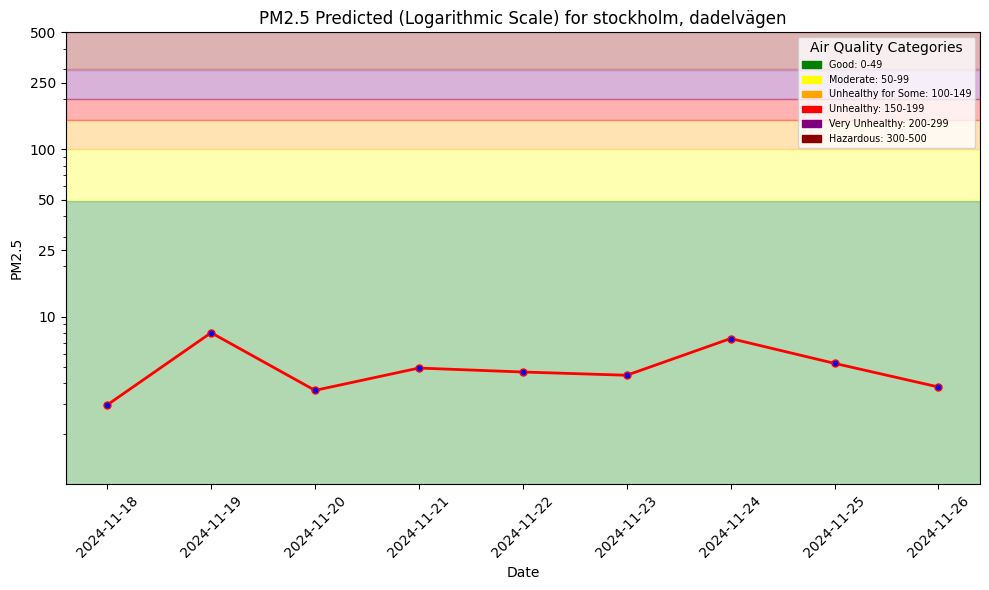

In [15]:
file_path = "../../docs/air-quality-with-lags/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_with_lags',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_with_lags_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1174688/jobs/named/aq_predictions_with_lags_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f65f8377440>, None)

In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.04s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,2.5,0.0,10.895576,277.594543,stockholm,1.0,1.23,1.5,2.971549,dadelvägen,sweden,1


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_with_lags(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_with_lags_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1174688/jobs/named/aq_predictions_with_lags_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,6.45,0.0,18.388212,246.948669,stockholm,1.23,1.5,1.5,1.485294,1.0,dadelvägen,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

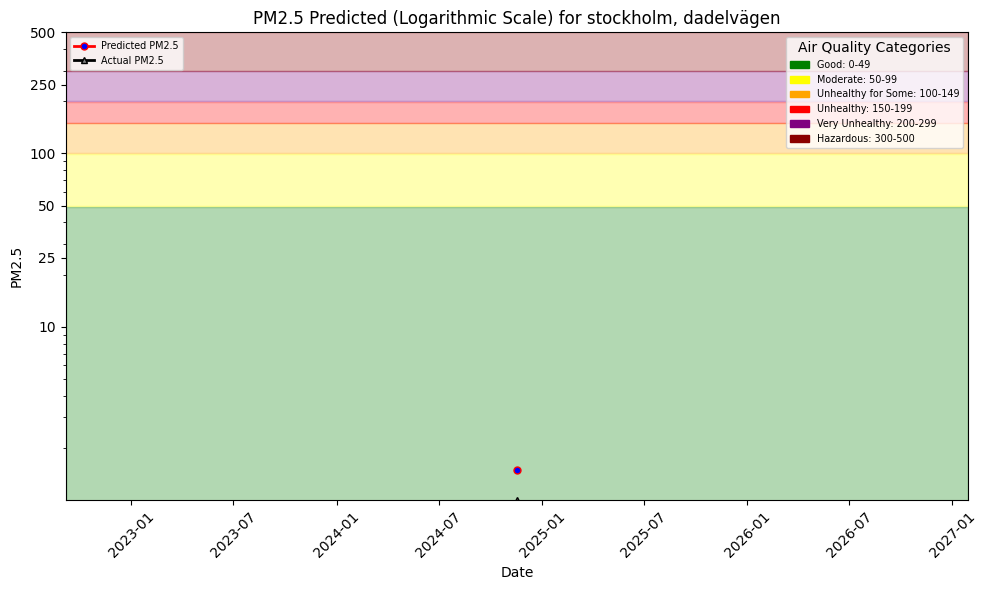

In [20]:
file_path = "../../docs/air-quality-with-lags/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---